In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
UA = gpd.read_file("Data/Current_UA/Current_UA.shp")
glasgow_simd = gpd.read_file("Data/Glasgow_simd/Glasgow_simd.shp")
simd_pop = pd.read_csv("Data/simd2020_withinds.csv")
vacant_land = gpd.read_file("Data/VDL_centroids/VDL_centroids.shp")

<AxesSubplot:>

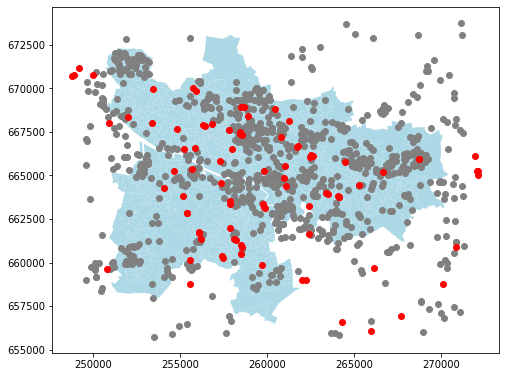

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
glasgow_simd.plot(ax=ax,color="lightblue")
vacant_land.plot(ax=ax,color="grey")
UA.plot(ax=ax,color="red")

In [4]:
from routingpy import OSRM
import json
import numpy as np

In [5]:
vdl = np.array(list(zip(vacant_land.to_crs(epsg=4326).geometry.x,
                  vacant_land.to_crs(epsg=4326).geometry.y))).tolist()

In [6]:
dz = np.array(list(zip(glasgow_simd.centroid.to_crs(epsg=4326).geometry.x,
                  glasgow_simd.centroid.to_crs(epsg=4326).geometry.y))).tolist()

In [7]:
ua = np.array(list(zip(UA.to_crs(epsg=4326).geometry.x,
                  UA.to_crs(epsg=4326).geometry.y))).tolist()

In [8]:
%%time
client = OSRM(base_url="http://localhost:4000")

osrm_routing_matrix_dz = client.matrix(
    profile="walking",
    dry_run=False,
    locations=vdl + dz,
    sources=list(range(0, len(vdl))),
    destinations=list(range(len(vdl), len(dz) + len(vdl))),
)
cost_matrix_dz_vdl = np.array(osrm_routing_matrix_dz.durations).T

CPU times: user 358 ms, sys: 38.1 ms, total: 397 ms
Wall time: 17.8 s


In [9]:
cost_matrix_dz_vdl.shape

(746, 884)

In [10]:
%%time
client = OSRM(base_url="http://localhost:4000")

osrm_routing_matrix_ua = client.matrix(
    profile="walking",
    dry_run=False,
    locations=ua + dz,
    sources=list(range(0, len(ua))),
    destinations=list(range(len(ua), len(dz) + len(ua))),
)
cost_matrix_dz_ua = np.array(osrm_routing_matrix_ua.durations).T

CPU times: user 77.8 ms, sys: 7.49 ms, total: 85.2 ms
Wall time: 3.66 s


In [11]:
cost_matrix_dz_ua.shape

(746, 88)

In [12]:
np.save("cost_matrix_dz_ua.npy",cost_matrix_dz_ua)
np.save("cost_matrix_dz_vdl.npy",cost_matrix_dz_vdl)